In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import csv as csv
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV   #Performing grid search
from scipy.stats import skew
from collections import OrderedDict
from sklearn.inspection import permutation_importance
import shap
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import joblib
import numbers

In [20]:
seed = 41

In [21]:
train_dataset=pd.read_csv('IL_ECW_cleaned.csv', header=0)
train_dataset

,Name,SMILES,Anion_Name,Cation_Name,Anion_SMILES,Cation_SMILES,Anion_LUMO,Cation_LUMO,Anion_HOMO,Cation_HOMO,...,Anion_fr_sulfonamd,Anion_fr_sulfone,Anion_fr_term_acetylene,Anion_fr_tetrazole,Anion_fr_thiazole,Anion_fr_thiocyan,Anion_fr_thiophene,Anion_fr_unbrch_alkane,Anion_fr_urea,Cation_SMILES_type
0,1-butyl-3-methylimidazolium.bis(trifluoromethy...,CCCCn1cc[n+](C)c1.O=S(=O)([N-]S(=O)(=O)C(F)(F)...,bis(trifluoromethylsulfonyl)imide,1-butyl-3-methylimidazolium,O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F,CCCCn1cc[n+](C)c1,0.15788,-0.18600,-0.14977,-0.43175,...,2,2,0,0,0,0,0,0,0,imidazolium
1,1-butyl-3-methylimidazolium.triflate,CCCCn1cc[n+](C)c1.O=S(=O)([O-])C(F)(F)F,triflate,1-butyl-3-methylimidazolium,O=S(=O)([O-])C(F)(F)F,CCCCn1cc[n+](C)c1,0.25497,-0.18600,-0.09102,-0.43175,...,0,1,0,0,0,0,0,0,0,imidazolium
2,1-butyl-3-methylimidazolium.diethyl-phosphate,CCCCn1cc[n+](C)c1.CCOP(=O)([O-])OCC,diethyl-phosphate,1-butyl-3-methylimidazolium,CCOP(=O)([O-])OCC,CCCCn1cc[n+](C)c1,0.16684,-0.18600,-0.07263,-0.43175,...,0,0,0,0,0,0,0,0,0,imidazolium
3,1-butyl-3-methylimidazolium.dimethyl-phosphate,CCCCn1cc[n+](C)c1.COP(=O)([O-])OC,dimethyl-phosphate,1-butyl-3-methylimidazolium,COP(=O)([O-])OC,CCCCn1cc[n+](C)c1,0.18115,-0.18600,-0.07629,-0.43175,...,0,0,0,0,0,0,0,0,0,imidazolium
4,1-butyl-3-methylimidazolium.methyl-sulfate,CCCCn1cc[n+](C)c1.COS(=O)(=O)[O-],methyl-sulfate,1-butyl-3-methylimidazolium,COS(=O)(=O)[O-],CCCCn1cc[n+](C)c1,0.18867,-0.18600,-0.07519,-0.43175,...,0,1,0,0,0,0,0,0,0,imidazolium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119797,Cationname607.Anionname204,CCC[N+]12CCC(CC1)CC2.F[B-](F)(F)c1cccc(C(F)(F)...,Anionname204,Cationname607,F[B-](F)(F)c1cccc(C(F)(F)F)c1,CCC[N+]12CCC(CC1)CC2,0.09832,-0.12483,-0.12387,-0.46630,...,0,0,0,0,0,0,0,0,0,piperidinium
119798,Cationname607.Anionname205,CCC[N+]12CCC(CC1)CC2.NC(CO)C(=O)[O-],Anionname205,Cationname607,NC(CO)C(=O)[O-],CCC[N+]12CCC(CC1)CC2,0.18685,-0.12483,-0.04900,-0.46630,...,0,0,0,0,0,0,0,1,0,piperidinium
119799,Cationname607.Anionname207,CCC[N+]12CCC(CC1)CC2.CCS(=O)(=O)[O-],Anionname207,Cationname607,CCS(=O)(=O)[O-],CCC[N+]12CCC(CC1)CC2,0.17700,-0.12483,-0.06034,-0.46630,...,0,1,0,0,0,0,0,0,0,piperidinium
119800,Cationname607.Anionname211,CCC[N+]12CCC(CC1)CC2.F[B-](F)(F)c1ccccc1,Anionname211,Cationname607,F[B-](F)(F)c1ccccc1,CCC[N+]12CCC(CC1)CC2,0.13494,-0.12483,-0.10118,-0.46630,...,0,0,0,0,0,0,0,0,0,piperidinium


In [22]:
# 去除离群值
def remove_outliers(df, property_col, outlier_factor=1.5):

    if property_col not in df.columns:
        raise ValueError(f"{property_col} not exist")

    Q1 = df[property_col].quantile(0.25)
    Q3 = df[property_col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - outlier_factor * IQR
    upper_bound = Q3 + outlier_factor * IQR

    non_outliers = df.loc[(df[property_col] >= lower_bound) & (df[property_col] <= upper_bound)].copy()
    
    return non_outliers



In [23]:
train_dataset = remove_outliers(train_dataset, property_col='ECW (V)', outlier_factor=1.5)

In [24]:
drop_columns=["Name","SMILES","Cation_SMILES","Anion_SMILES","Cation_Name","Anion_Name",
              "Cation_HOMO","Anion_HOMO","Cation_LUMO","Anion_LUMO","Cation_SMILES_type"]
for drop_column in drop_columns:
    try:
        # test_dataset.drop(drop_column,axis=1,inplace=True)
        train_dataset.drop(drop_column,axis=1,inplace=True)
    except KeyError as e:
        print(f"Error: {e}")
    
all_features= [col for col in train_dataset.columns if col not in ['ECW (V)']]
train_dataset.describe() #Describle

,ECW (V),Cation_BalabanJ,Cation_BertzCT,Cation_EState_VSA1,Cation_EState_VSA2,Cation_EState_VSA3,Cation_EState_VSA4,Cation_EState_VSA5,Cation_EState_VSA6,Cation_EState_VSA7,...,Anion_fr_sulfide,Anion_fr_sulfonamd,Anion_fr_sulfone,Anion_fr_term_acetylene,Anion_fr_tetrazole,Anion_fr_thiazole,Anion_fr_thiocyan,Anion_fr_thiophene,Anion_fr_unbrch_alkane,Anion_fr_urea
count,118347.000000,118347.000000,118347.000000,118347.000000,118347.000000,118347.000000,118347.000000,118347.000000,118347.000000,118347.000000,...,118347.000000,118347.000000,118347.000000,118347.0,118347.000000,118347.0,118347.0,118347.0,118347.000000,118347.0
mean,2.924113,2.610476,243.097811,1.458371,1.591136,2.990326,7.442596,32.321702,3.920202,8.734486,...,0.291372,0.068291,0.246318,0.0,0.006439,0.0,0.0,0.0,2.448427,0.0
std,1.522573,0.795225,172.895393,6.105836,4.085987,6.108399,8.533144,36.231343,9.147614,14.000040,...,0.564810,0.354232,0.521961,0.0,0.079983,0.0,0.0,0.0,4.322389,0.0
min,0.000272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
25%,1.796016,2.042064,114.280840,0.000000,0.000000,0.000000,0.000000,5.563451,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
50%,2.821456,2.426522,206.421729,0.000000,0.000000,0.000000,6.544756,19.262465,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
75%,4.013904,3.043758,316.973053,0.000000,0.000000,5.824404,12.462662,50.763614,4.899910,13.847474,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,3.000000,0.0
max,7.431312,7.076483,938.743625,85.964944,38.524930,57.010660,43.751886,216.741949,61.997467,67.206464,...,3.000000,2.000000,3.000000,0.0,1.000000,0.0,0.0,0.0,20.000000,0.0


In [8]:
def plot_properties_distribution(df, col='ECW (V)', output=True):

    if f'{col}' not in df.columns:
        raise ValueError(f"{col} not exist")

    data = df[col]

    plt.figure(figsize=(1.75, 1.3125)) 
    plt.hist(data, bins=50, color='skyblue', edgecolor='black',
             weights=np.ones(len(data)) / len(data), lw=0.25) 

    plt.xlabel(f'ECW(V)')
    plt.ylabel('Frequency')
    
    if output:
        plt.tight_layout() 
        plt.savefig(f"{col}_original_data_distribution.tif", format='tif', dpi=300)

    # 显示图形
    plt.show()

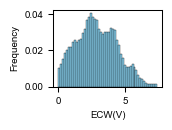

In [9]:
plot_properties_distribution(train_dataset, col='ECW (V)')

In [10]:
non_categorical_features= [col for col in train_dataset.columns if col not in ['ECW (V)'] ]
numeric_feats = train_dataset[non_categorical_features].dtypes[train_dataset.dtypes != "object"].index
# x->log(1+x)
# train_dataset[numeric_feats] = np.log1p(train_dataset[numeric_feats])

In [11]:
all_features= [col for col in train_dataset.columns if col not in ['ECW (V)']]

In [12]:
numeric_feats

Index(['Cation_BalabanJ', 'Cation_BertzCT', 'Cation_EState_VSA1',
       'Cation_EState_VSA2', 'Cation_EState_VSA3', 'Cation_EState_VSA4',
       'Cation_EState_VSA5', 'Cation_EState_VSA6', 'Cation_EState_VSA7',
       'Cation_EState_VSA8',
       ...
       'Anion_fr_sulfide', 'Anion_fr_sulfonamd', 'Anion_fr_sulfone',
       'Anion_fr_term_acetylene', 'Anion_fr_tetrazole', 'Anion_fr_thiazole',
       'Anion_fr_thiocyan', 'Anion_fr_thiophene', 'Anion_fr_unbrch_alkane',
       'Anion_fr_urea'],
      dtype='object', length=366)

In [13]:
train_dataset = train_dataset[train_dataset.Cation_BertzCT < 350]
train_dataset = train_dataset[train_dataset.Anion_BertzCT < 350]

In [14]:
X = train_dataset[numeric_feats]
y = train_dataset['ECW (V)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [18]:
def XGBoost_model_para_search(X_train, X_test, y_train, y_test, search_method="random"):
    start_time = time.time()

    if search_method == "grid":
        param_grid = {
            'max_depth': [3, 5, 7, 9],
            'min_child_weight': [1, 3, 5, 7],
            'subsample': [0.6, 0.7, 0.8, 0.9],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 10],
            'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
        }

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, tree_method='approx')

        grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=32)

        grid_search.fit(X_train, y_train)
       
        end_time = time.time()
        print("Training time: {:.2f} seconds".format(end_time - start_time))

        print("Best parameters found: ", grid_search.best_params_)

        return grid_search
    
    if search_method == "random":
        param_distributions = {
            'max_depth': randint(3, 10),
            'min_child_weight': randint(1, 8),
            'subsample': uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.6, 0.4),
            'learning_rate': uniform(0.01, 0.2),
            'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 10],
            'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1, 10, 100]
        }

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, tree_method='approx')
    

        random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, 
                                           n_iter=256, cv=5, scoring="neg_mean_squared_error", 
                                           verbose=1, n_jobs=32, random_state=42)

        random_search.fit(X_train, y_train)

        end_time = time.time()
        print("Training time: {:.2f} seconds".format(end_time - start_time))

        print("Best parameters found: ", random_search.best_params_)

        return random_search

In [19]:
grid_search = XGBoost_model_para_search(X_train, X_test, y_train, y_test)
xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Training time: 7100.43 seconds
Best parameters found:  {'colsample_bytree': 0.9402909840065818, 'learning_rate': 0.15919490510974363, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 1, 'reg_lambda': 0.01, 'subsample': 0.9753361827284152}


In [135]:
def evaluate_model(model, X_test, y_test, figname, width=0.75, xlabel='real', ylabel='predictiton', fontsize=7, figsize=(4, 4), output=False):

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print("MSE (Mean Squared Error): {:.2f}".format(mse))

    mae = mean_absolute_error(y_test, y_pred)
    print("MAE (Mean Absolute Error): {:.2f}".format(mae))

    rmse = np.sqrt(mse)  
    print("RMSE (Root Mean Squared Error): {:.2f}".format(rmse))

    r2 = r2_score(y_test, y_pred)
    print("R^2 Score: {:.2f}".format(r2))
    
    plt.figure(figsize=figsize)
    plt.scatter(y_test, y_pred, alpha=0.5, s=10)  
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1) 

    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tick_params(axis='x', width=width, labelsize=fontsize) 
    plt.tick_params(axis='y', width=width, labelsize=fontsize) 
    
    # 获取当前轴对象
    ax = plt.gca()
    ax.spines['top'].set_linewidth(width) 
    ax.spines['right'].set_linewidth(width)
    ax.spines['bottom'].set_linewidth(width)
    ax.spines['left'].set_linewidth(width) 

    if output:
    # 保存图像
        plt.tight_layout() 
        plt.savefig(f"{figname}_model_evaluate.tif", format='tif', dpi=300)

    plt.show()


MSE (Mean Squared Error): 0.00
MAE (Mean Absolute Error): 0.03
RMSE (Root Mean Squared Error): 0.05
R^2 Score: 1.00


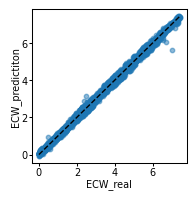

In [136]:
evaluate_model(xgb_model, X_test, y_test, figname="ECW", xlabel='ECW real', ylabel='ECW predictiton', figsize=(2, 2), output=False)

In [15]:
import math 
def evaluate_model_new(model, X_test, y_test, figname, figsize=(2.3, 2.3), output=False):

    plt.rcParams["font.family"] = "Arial"

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print("MSE (Mean Squared Error): {:.2f}".format(mse))

    mae = mean_absolute_error(y_test, y_pred)
    print("MAE (Mean Absolute Error): {:.2f}".format(mae))

    rmse = np.sqrt(mse)
    print("RMSE (Root Mean Squared Error): {:.2f}".format(rmse))

    r2 = r2_score(y_test, y_pred)
    print("R^2 Score: {:.2f}".format(r2))
   
    f, ax = plt.subplots(figsize=figsize)
    ax.scatter(y_pred, y_test, s=0.5)

    ax.axline((1, 1), slope=1, color="red", linestyle="--")  
    plt.xlabel("Predicted Value") 
    plt.ylabel("Ground Truth") 

    ax.set_aspect('equal', adjustable='box')

    min_value = math.floor(min(y_pred.min(), y_test.min()))
    max_value = math.ceil(max(y_pred.max(), y_test.max())) 
  
    interval = (max_value - min_value) / 5  

    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_xticks(np.arange(min_value, max_value + interval, interval))
    ax.set_yticks(np.arange(min_value, max_value + interval, interval))
  
    text_str = f"MAE = {mae:.2f}\nMSE = {mse:.2f}\nR² = {r2:.2f}"
    plt.text(
        0.05, 0.95, text_str,
        transform=ax.transAxes, 
        fontsize=7, color="black",
        verticalalignment="top", horizontalalignment="left"
    )

    for spine in ax.spines.values():
        spine.set_linewidth(0.75)

    if output:
        plt.tight_layout()
        plt.savefig(f"{figname}.png", dpi=300) # , bbox_inches="tight"

    plt.show()


MSE (Mean Squared Error): 0.00
MAE (Mean Absolute Error): 0.03
RMSE (Root Mean Squared Error): 0.05
R^2 Score: 1.00


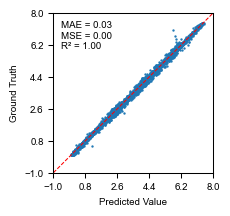

In [17]:
def load_model_with_joblib_and_get_features(filename):

    model = joblib.load(filename)
    feature_names = model.get_booster().feature_names
    return model, feature_names

ECW_xgb_model, ECW_feature_names = load_model_with_joblib_and_get_features('ECW_xgb_model.joblib')

final_X_test = X_test[ECW_feature_names]

evaluate_model_new(ECW_xgb_model, final_X_test, y_test, figname='ECW_val', figsize=(2.3, 2.3), output=True)

In [22]:
def evaluate_feature_importance(xgb_model,importance_type='gain'):

    feature_importance = xgb_model.get_booster().get_score(importance_type=importance_type)
  
    features = X.columns
    importance_dict = {feature: 0 for feature in features}

    for feature, importance in feature_importance.items():
        importance_dict[feature] = importance
    
    importance_df = pd.DataFrame({
        'Feature': importance_dict.keys(),
        'Importance': importance_dict.values()
    }).sort_values(by='Importance', ascending=False)
    
    print(importance_df)

    xgb.plot_importance(xgb_model, importance_type=importance_type)
    plt.show()

    return feature_importance

                      Feature  Importance
70            Cation_SMR_VSA6  366.524445
225      Anion_NumHeteroatoms  336.313110
270         Anion_VSA_EState1   96.995270
14       Cation_HallKierAlpha   86.765350
57           Cation_PEOE_VSA9   86.722946
..                        ...         ...
147         Cation_fr_isocyan    0.000000
148     Cation_fr_isothiocyan    0.000000
149          Cation_fr_ketone    0.000000
150  Cation_fr_ketone_Topliss    0.000000
180       Cation_fr_thiophene    0.000000

[366 rows x 2 columns]


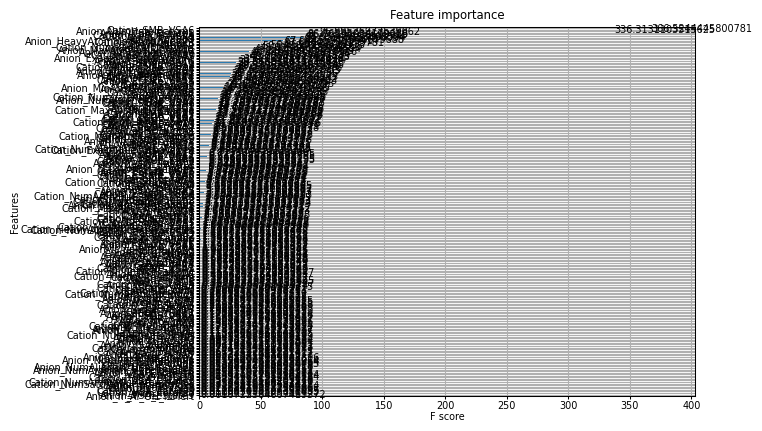

235


In [182]:
gain_feature_importance = evaluate_feature_importance(xgb_model,importance_type='gain')
print(len(gain_feature_importance))

In [181]:
sorted_xgboost_gain_importance = OrderedDict(sorted(gain_feature_importance.items(), key=lambda t: t[1], reverse=True))
print(len(sorted_xgboost_gain_importance))
sorted_xgboost_gain_importance

235


OrderedDict([('Cation_SMR_VSA6', 366.5244445800781),
             ('Anion_NumHeteroatoms', 336.3131103515625),
             ('Anion_VSA_EState1', 96.99526977539062),
             ('Cation_HallKierAlpha', 86.76535034179688),
             ('Cation_PEOE_VSA9', 86.72294616699219),
             ('Anion_Kappa1', 85.55345153808594),
             ('Anion_fr_COO', 84.57566833496094),
             ('Anion_HeavyAtomMolecularWeight', 83.56417846679688),
             ('Cation_FractionCSP3', 67.9445571899414),
             ('Cation_fr_nitroso', 67.68672180175781),
             ('Anion_Kappa2', 56.8510856628418),
             ('Cation_NumRadicalElectrons', 50.24384689331055),
             ('Anion_SMR_VSA10', 48.02504348754883),
             ('Anion_MaxAbsPartialCharge', 43.642845153808594),
             ('Anion_MinPartialCharge', 43.35708999633789),
             ('Cation_fr_Imine', 40.446598052978516),
             ('Cation_EState_VSA10', 40.44640350341797),
             ('Anion_SMR_VSA7', 40.2080421

In [177]:
def permutation_feature_importance(xgb_model, X, y, n_repeats=30):

    results = permutation_importance(xgb_model, X, y, n_repeats=n_repeats, random_state=0, n_jobs=32)

    importance_mean = results.importances_mean
    feature_names = X.columns.tolist()

    sorted_idx = np.argsort(importance_mean)[::-1]
    sorted_importance_mean = importance_mean[sorted_idx]
    sorted_feature_names = [feature_names[index] for index in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importance_mean)), sorted_importance_mean, align='center')
    plt.yticks(range(len(sorted_importance_mean)), sorted_feature_names)
    plt.gca().invert_yaxis()
    plt.xlabel('Permutation Importance')
    plt.title('Feature Importance')
    plt.show()

    permutation_feature_importance_dict = {name: value for name, value in zip(sorted_feature_names, sorted_importance_mean)}

    return permutation_feature_importance_dict

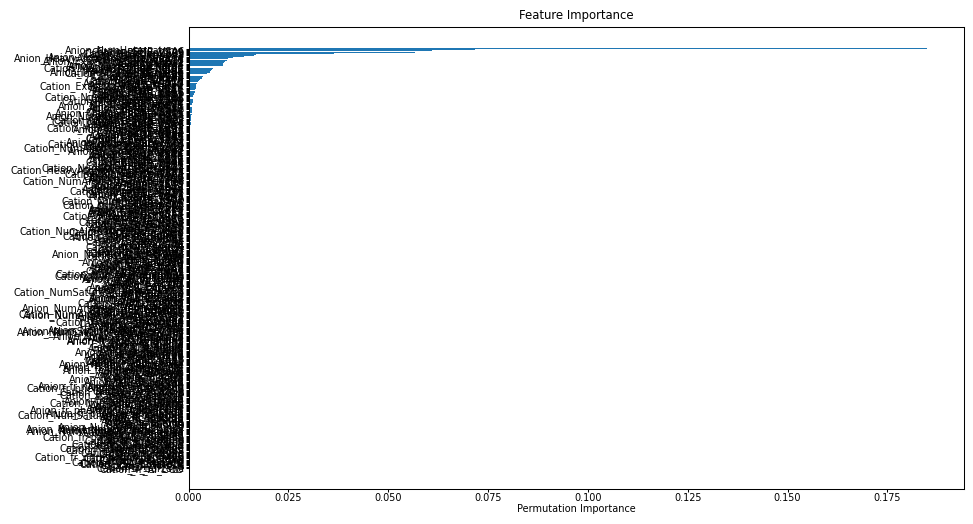

In [166]:
permutation_feature_importance_dict = permutation_feature_importance(xgb_model, X, y, n_repeats=30)

In [172]:
sorted_permutation_importance = OrderedDict(sorted(permutation_feature_importance_dict.items(), key=lambda t: t[1], reverse=True))
sorted_permutation_importance

OrderedDict([('Anion_NumHeteroatoms', 0.18482246253100537),
             ('Cation_SMR_VSA6', 0.07171207977754429),
             ('Cation_PEOE_VSA9', 0.06093520352638841),
             ('Cation_FractionCSP3', 0.056756809315015665),
             ('Cation_HallKierAlpha', 0.036372489421720854),
             ('Anion_Kappa1', 0.016783680522481643),
             ('Anion_MaxAbsPartialCharge', 0.016416219590873225),
             ('Anion_HeavyAtomMolecularWeight', 0.013810789539134527),
             ('Cation_PEOE_VSA11', 0.011115478724833806),
             ('Anion_SMR_VSA10', 0.00999388539109194),
             ('Anion_ExactMolecularWeight', 0.0096668499087464),
             ('Cation_Kappa1', 0.00916487615164382),
             ('Anion_Kappa2', 0.008805936609978837),
             ('Anion_MaxPartialCharge', 0.008731991106310615),
             ('Anion_MinPartialCharge', 0.008613180240508814),
             ('Anion_EState_VSA1', 0.00850466869650874),
             ('Cation_MaxAbsPartialCharge', 0.00660

In [188]:
def SHAP(model, X, model_name=None, output=False):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    shap_sum = np.abs(shap_values).mean(axis=0)

    SHAP_feature_importance_dict = dict(zip(X.columns, shap_sum))

    if output:
        plt.figure(figsize=(7, 2), dpi=300)
        shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], 
                        matplotlib=True, show=False)
        plt.savefig(f'{model_name}_force_plot.tif')
        
        plt.figure(figsize=(7, 5), dpi=300)
        shap.summary_plot(shap_values, X, show=False, plot_size=None)
        plt.savefig(f'{model_name}_summary_plot.tif')
        plt.show()

    return SHAP_feature_importance_dict


In [164]:
SHAP_feature_importance_dict = SHAP(xgb_model, X)

In [165]:
sorted_SHAP_importance = OrderedDict(sorted(SHAP_feature_importance_dict.items(), key=lambda t: t[1], reverse=True))
sorted_SHAP_importance

OrderedDict([('Anion_NumHeteroatoms', 0.42088652),
             ('Cation_SMR_VSA6', 0.30007496),
             ('Cation_PEOE_VSA9', 0.2406036),
             ('Cation_FractionCSP3', 0.22042574),
             ('Cation_HallKierAlpha', 0.15321639),
             ('Anion_SMR_VSA10', 0.082017384),
             ('Anion_HeavyAtomMolecularWeight', 0.08172548),
             ('Anion_MaxAbsPartialCharge', 0.07857491),
             ('Anion_EState_VSA1', 0.073733255),
             ('Cation_PEOE_VSA11', 0.06874964),
             ('Anion_MaxPartialCharge', 0.06590027),
             ('Anion_Kappa1', 0.061771303),
             ('Cation_PEOE_VSA7', 0.059939228),
             ('Anion_MinPartialCharge', 0.05622073),
             ('Anion_Kappa3', 0.04966263),
             ('Cation_MaxAbsPartialCharge', 0.04841372),
             ('Cation_Kappa1', 0.047699526),
             ('Cation_SlogP_VSA2', 0.047314797),
             ('Cation_PEOE_VSA8', 0.04471751),
             ('Cation_MinPartialCharge', 0.044470765),
 

In [167]:
def normalize_and_average_dicts(*dicts):
    if not dicts:
        raise ValueError("input at least one dict")

    feature_importances = []
    feature_names = set()

    for d in dicts:
        feature_importances.append(list(d.values()))
        feature_names.update(d.keys())

    feature_names = sorted(list(feature_names))

    importances_matrix = np.zeros((len(dicts), len(feature_names)))

    for i, d in enumerate(dicts):
        for j, feature in enumerate(feature_names):
            importances_matrix[i, j] = d.get(feature, 0)

    scaler = MinMaxScaler()
    importances_matrix = scaler.fit_transform(importances_matrix.T).T

    average_importances = np.mean(importances_matrix, axis=0)

    averaged_dict = dict(zip(feature_names, average_importances))

    return dict(sorted(averaged_dict.items(), key=lambda item: item[1], reverse=True))

In [168]:
normalize_and_average_importance_dict, importances_matrix = normalize_and_average_dicts(sorted_xgboost_gain_importance, sorted_permutation_importance, sorted_SHAP_importance)
normalize_and_average_importance_dict

{'Anion_NumHeteroatoms': 0.972524493545373,
 'Cation_SMR_VSA6': 0.7003215531565782,
 'Cation_PEOE_VSA9': 0.37932132765516996,
 'Cation_FractionCSP3': 0.3387271314734503,
 'Cation_HallKierAlpha': 0.2658514043206911,
 'Anion_HeavyAtomMolecularWeight': 0.1656300551410727,
 'Anion_Kappa1': 0.15699760183903969,
 'Anion_MaxAbsPartialCharge': 0.13152764500346223,
 'Anion_SMR_VSA10': 0.1266564881201249,
 'Anion_VSA_EState1': 0.11470518536095152,
 'Anion_fr_COO': 0.10571311527524403,
 'Anion_Kappa2': 0.10053913767427279,
 'Anion_MinPartialCharge': 0.09949068857452992,
 'Cation_PEOE_VSA11': 0.09674354574125606,
 'Anion_MaxPartialCharge': 0.09299672378747496,
 'Anion_EState_VSA1': 0.09101143346401046,
 'Cation_Kappa1': 0.07402701800295068,
 'Anion_ExactMolecularWeight': 0.07274826901450944,
 'Cation_MinPartialCharge': 0.07179496681602833,
 'Cation_fr_nitroso': 0.07069084242275962,
 'Cation_PEOE_VSA7': 0.07034442483434644,
 'Anion_HallKierAlpha': 0.06946876475510211,
 'Cation_SlogP_VSA2': 0.068526

In [185]:
def create_dataframe_from_dicts(dict_list, column_headers):

    if not all(isinstance(d, dict) for d in dict_list):
        raise ValueError("All input values should be dictionaries.")
    
    # Check if the number of column headers matches the number of dictionaries
    if len(dict_list) != len(column_headers):
        raise ValueError("The number of column headers must match the number of dictionaries.")
    
    # Check if all dictionaries have the same keys and identify missing keys
    dict_keys_sets = [set(d.keys()) for d in dict_list]
    common_keys = set.intersection(*dict_keys_sets)
    
    if len(common_keys) != len(dict_keys_sets[0]):
        for i, key_set in enumerate(dict_keys_sets):
            missing_keys = common_keys.symmetric_difference(key_set)
            if missing_keys:
                print(f"Dictionary {i} is missing keys: {missing_keys}")
        raise ValueError("All dictionaries must have the same keys.")

    
    # Check if all keys are of type str, all values are numeric, and print the length of each dictionary
    for i, d in enumerate(dict_list):
        if not all(isinstance(key, str) for key in d.keys()):
            raise ValueError(f"Dictionary {i} contains non-string keys.")
        if not all(isinstance(value, numbers.Number) for value in d.values()):
            raise ValueError(f"Dictionary {i} contains non-numeric values.")
        print(f"Length of dictionary {i} (number of key-value pairs): {len(d)}")

    # Create DataFrame
    df_data = {'feature name': list(common_keys)}  # Initialize data, first column is feature name
    for header, d in zip(column_headers, dict_list):
        df_data[header] = [d[key] for key in df_data['feature name']]  # Add each dictionary's values in input order

    
    # Build DataFrame
    df = pd.DataFrame(df_data)
    
    return df

dicts = [
    sorted_xgboost_gain_importance,
    sorted_permutation_importance,
    sorted_SHAP_importance,
    normalize_and_average_importance_dict,
]

headers = ['xgboost_gain_feature_importance',
           'permutation_feature_importance',
           'SHAP_feature_importance',
           'normalize_and_average_importance',]

try:
    df = create_dataframe_from_dicts(dicts, headers)
    print(df)
    df.to_csv("ECW_feature_importance.csv", index=None)
except ValueError as e:
    print(f"An error occurred: {e}")

字典 0 的长度（含有键值对的数量）: 235
字典 1 的长度（含有键值对的数量）: 366
字典 2 的长度（含有键值对的数量）: 366
字典 3 的长度（含有键值对的数量）: 366
                 feature name  xgboost_gain_feature_importance  \
0                Anion_Kappa2                        56.851086   
1           Anion_EState_VSA2                         5.346085   
2             Anion_PEOE_VSA1                        25.054079   
3    Cation_NumAliphaticRings                         0.113256   
4             Anion_PEOE_VSA4                        25.319078   
..                        ...                              ...   
230            Anion_fr_ether                         0.255394   
231          Anion_PEOE_VSA13                         0.180277   
232           Cation_SMR_VSA1                        14.781202   
233          Cation_PEOE_VSA2                        15.358006   
234     Cation_NumHeteroatoms                        11.814663   

     permutation_feature_importance  SHAP_feature_importance  \
0                      8.805937e-03            

In [33]:
def correlation_analysis_with_feature_importance(X, feature_importance_dict, method_list=['pearson', 'spearman', 'kendall'], threshold=0.5, exclusion_threshold=0.9):

    correlation_matrix = pd.DataFrame(index=X.columns, columns=X.columns, data=0.0)

    for method in method_list:
        correlation_matrix += X.corr(method=method)
    correlation_matrix /= len(method_list)

    correlation_matrix_to_show = correlation_matrix.copy()
    correlation_matrix_to_show[np.abs(correlation_matrix_to_show) < threshold] = 0

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_to_show, annot=True, fmt='.2f', cmap='coolwarm', mask=correlation_matrix_to_show==0)
    plt.title(f'Average Correlation of Features (Display Threshold: {threshold})')
    plt.show()

    retained_features = X.columns.tolist()
    excluded_features = []

    for feature1 in X.columns:
        for feature2 in X.columns:
            if feature1 != feature2 and np.abs(correlation_matrix[feature1][feature2]) >= exclusion_threshold:
                if feature_importance_dict[feature1] < feature_importance_dict[feature2]:
                    if feature1 not in excluded_features:
                        excluded_features.append(feature1)
                        retained_features.remove(feature1)
                else:
                    if feature2 not in excluded_features:
                        excluded_features.append(feature2)
                        retained_features.remove(feature2)

    print("Excluded Features:", excluded_features)
    print("————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————————")
    print("Retained Features:", retained_features)

    return retained_features

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


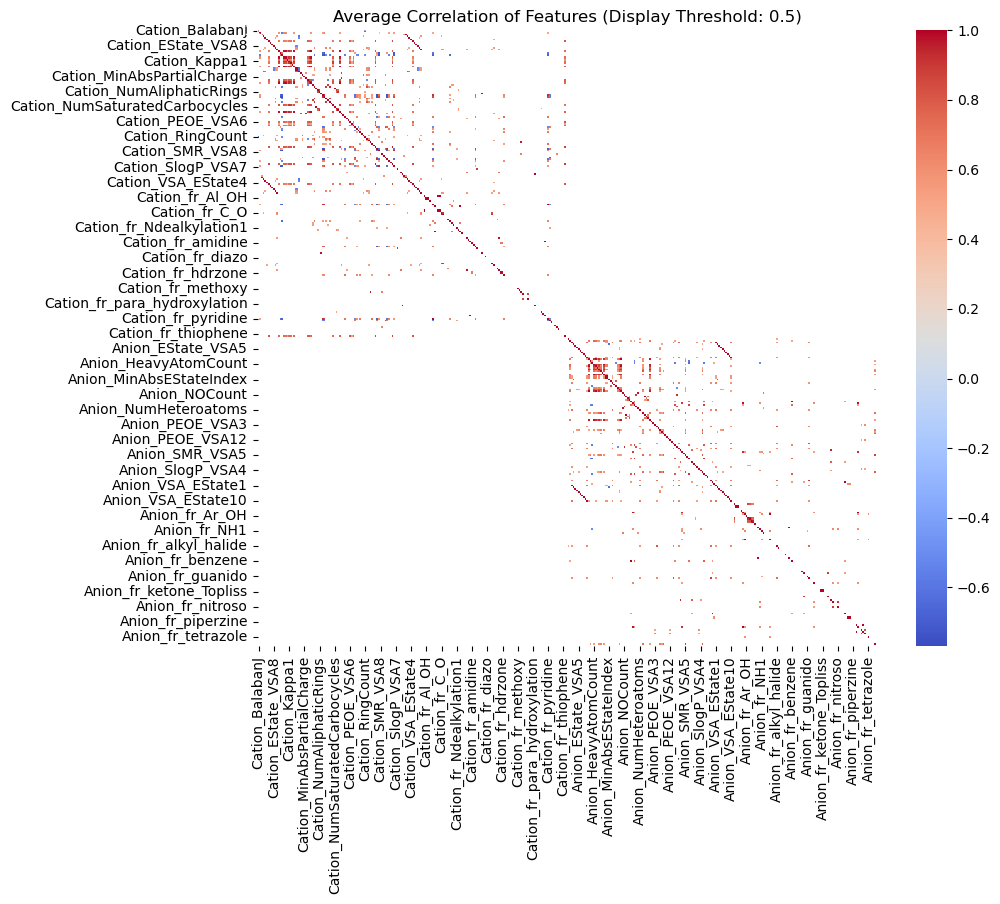

Excluded Features: ['Cation_VSA_EState1', 'Cation_EState_VSA2', 'Cation_VSA_EState3', 'Cation_VSA_EState4', 'Cation_VSA_EState5', 'Cation_VSA_EState6', 'Cation_VSA_EState7', 'Cation_VSA_EState8', 'Cation_VSA_EState9', 'Cation_VSA_EState10', 'Cation_HeavyAtomCount', 'Cation_HeavyAtomMolecularWeight', 'Cation_ExactMolecularWeight', 'Cation_LabuteASA', 'Cation_MolWt', 'Cation_Kappa2', 'Cation_MolMR', 'Cation_NumRotatableBonds', 'Cation_NumValenceElectrons', 'Cation_MaxEStateIndex', 'Cation_NOCount', 'Cation_NumSaturatedCarbocycles', 'Cation_NumSaturatedHeterocycles', 'Cation_NumSaturatedRings', 'Cation_fr_benzene', 'Cation_NumAromaticHeterocycles', 'Cation_fr_pyridine', 'Cation_NumHAcceptors', 'Cation_fr_nitrile', 'Cation_SlogP_VSA5', 'Cation_SlogP_VSA2', 'Cation_SMR_VSA7', 'Cation_fr_azide', 'Cation_fr_phenol', 'Cation_fr_COO', 'Cation_fr_COO2', 'Cation_fr_Al_OH_noTert', 'Cation_fr_Nhpyrrole', 'Cation_fr_C_O_noCOO', 'Cation_fr_halogen', 'Cation_fr_priamide', 'Cation_fr_alkyl_halide', 'Ca

In [34]:
retained_features = correlation_analysis_with_feature_importance(X, normalize_and_average_importance_dict)
print(retained_features)

In [35]:
filtered_numeric_feats = [feature for feature in numeric_feats if feature in retained_features]
filtered_numeric_feats

['Cation_BalabanJ',
 'Cation_BertzCT',
 'Cation_EState_VSA1',
 'Cation_EState_VSA3',
 'Cation_EState_VSA4',
 'Cation_EState_VSA5',
 'Cation_EState_VSA6',
 'Cation_EState_VSA7',
 'Cation_EState_VSA8',
 'Cation_EState_VSA9',
 'Cation_EState_VSA10',
 'Cation_FractionCSP3',
 'Cation_HallKierAlpha',
 'Cation_Ipc',
 'Cation_Kappa1',
 'Cation_Kappa3',
 'Cation_MaxAbsEStateIndex',
 'Cation_MinAbsEStateIndex',
 'Cation_MaxAbsPartialCharge',
 'Cation_MaxPartialCharge',
 'Cation_MinAbsPartialCharge',
 'Cation_MinPartialCharge',
 'Cation_MolLogP',
 'Cation_NHOHCount',
 'Cation_NumAliphaticCarbocycles',
 'Cation_NumAliphaticHeterocycles',
 'Cation_NumAliphaticRings',
 'Cation_NumAromaticCarbocycles',
 'Cation_NumAromaticRings',
 'Cation_NumHDonors',
 'Cation_NumHeteroatoms',
 'Cation_NumRadicalElectrons',
 'Cation_PEOE_VSA1',
 'Cation_PEOE_VSA2',
 'Cation_PEOE_VSA3',
 'Cation_PEOE_VSA4',
 'Cation_PEOE_VSA5',
 'Cation_PEOE_VSA6',
 'Cation_PEOE_VSA7',
 'Cation_PEOE_VSA8',
 'Cation_PEOE_VSA9',
 'Catio

In [36]:
filtered_X = train_dataset[filtered_numeric_feats]
y = train_dataset['ECW (V)']
n_splits = 5 

filtered_X_train, filtered_X_test, filtered_y_train, filtered_y_test = train_test_split(filtered_X, y, test_size=0.2, random_state=seed)

filtered_grid_search = XGBoost_model_para_search(filtered_X_train, filtered_X_test, filtered_y_train, filtered_y_test)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Training time: 5949.77 seconds
Best parameters found:  {'colsample_bytree': 0.9160702162124823, 'learning_rate': 0.1311919949562023, 'max_depth': 4, 'min_child_weight': 7, 'reg_alpha': 1e-05, 'reg_lambda': 0, 'subsample': 0.9659838702175123}


In [37]:
best_params = filtered_grid_search.best_params_
filtered_xgb_model = xgb.XGBRegressor(**best_params)
filtered_model = filtered_grid_search.best_estimator_
rfecv = RFECV(estimator=filtered_xgb_model, step=1, cv=KFold(n_splits), scoring='neg_mean_squared_error')
rfecv.fit(filtered_X, y)
print("Optimal number of features : %d" % rfecv.n_features_)
print("Feature ranking: %s" % rfecv.ranking_)
selected_features = [f for f, s in zip(filtered_X.columns, rfecv.support_) if s]
print("Selected features: %s" % selected_features)

Optimal number of features : 125
Feature ranking: [  1   1  16   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1  13   1   5   1  11   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2   1   1
   1   1   1   1   1   1   1  78  82  89   1  77  74  94  95  88  99  84
  61 101  79  60 124  86   1 110 126  87 130 122 123 129  97 125  98   1
 107  91 119 127 104 116  68 111  42 149  69 133   1 155 106 131  83 108
 132  54  75  76   4  72  39  81   6  85   1 142 137 134  50 135   1  31
  48 153   1 150   3 143 154 144 148 157 158   1 147   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1 160  59  90 159 140   1   1 146  53 139 145   1   1   1   1
   1   1 100 136   1   1   1   1 152   1 105   1   1 117   1   1 103   1
 151   1   1   1  12   1   1 138 141 118 121  10   1   1   1 120   1  64
 102 115 128   1 109  65 156  93   1  17  73  96   9   1  21  66   1  57
 

In [187]:
def export_features_to_txt(features, filename):
    features = [str(feature) for feature in features]
    
    with open(filename, 'w') as file:
        for feature in features:
            file.write(feature + '\n')
            
    print("Selected features have been exported to selected_features.txt")

export_features_to_txt(selected_features, 'ECW_selected_features.txt')

Selected features have been exported to selected_features.txt


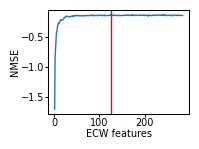

In [134]:
plt.figure(figsize=(2, 1.5)) 
plt.xlabel("ECW features")
plt.ylabel("NMSE")

mean_score = np.mean([rfecv.cv_results_[f"split{i}_test_score"] for i in range(n_splits)], axis=0)

plt.plot(range(1, len(mean_score) + 1), mean_score, lw=1)
plt.axvline(x=rfecv.n_features_, color='r', lw=1)
plt.tight_layout() 
plt.savefig(f"ECW_RFECV.tif", format='tif', dpi=300)
plt.show()

In [39]:
RFE_filtered_numeric_feats = [feature for feature in filtered_numeric_feats if feature in selected_features]
RFE_filtered_numeric_feats

['Cation_BalabanJ',
 'Cation_BertzCT',
 'Cation_EState_VSA3',
 'Cation_EState_VSA4',
 'Cation_EState_VSA5',
 'Cation_EState_VSA6',
 'Cation_EState_VSA7',
 'Cation_EState_VSA8',
 'Cation_EState_VSA9',
 'Cation_EState_VSA10',
 'Cation_FractionCSP3',
 'Cation_HallKierAlpha',
 'Cation_Ipc',
 'Cation_Kappa1',
 'Cation_Kappa3',
 'Cation_MaxAbsEStateIndex',
 'Cation_MinAbsEStateIndex',
 'Cation_MaxAbsPartialCharge',
 'Cation_MaxPartialCharge',
 'Cation_MinAbsPartialCharge',
 'Cation_MinPartialCharge',
 'Cation_MolLogP',
 'Cation_NHOHCount',
 'Cation_NumAliphaticCarbocycles',
 'Cation_NumAliphaticHeterocycles',
 'Cation_NumAromaticCarbocycles',
 'Cation_NumHDonors',
 'Cation_NumRadicalElectrons',
 'Cation_PEOE_VSA1',
 'Cation_PEOE_VSA2',
 'Cation_PEOE_VSA3',
 'Cation_PEOE_VSA4',
 'Cation_PEOE_VSA5',
 'Cation_PEOE_VSA6',
 'Cation_PEOE_VSA7',
 'Cation_PEOE_VSA8',
 'Cation_PEOE_VSA9',
 'Cation_PEOE_VSA10',
 'Cation_PEOE_VSA11',
 'Cation_PEOE_VSA12',
 'Cation_PEOE_VSA13',
 'Cation_PEOE_VSA14',
 'C

In [40]:
final_X = train_dataset[RFE_filtered_numeric_feats]
y = train_dataset['ECW (V)']
n_splits = 5

final_X_train, final_X_test, final_y_train, final_y_test = train_test_split(final_X, y, test_size=0.2, random_state=seed)

final_grid_search = XGBoost_model_para_search(final_X_train, final_X_test, final_y_train, final_y_test)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Training time: 3154.01 seconds
Best parameters found:  {'colsample_bytree': 0.6443563283247326, 'learning_rate': 0.09786730037315403, 'max_depth': 5, 'min_child_weight': 7, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8253102287905535}


MSE (Mean Squared Error): 0.00
MAE (Mean Absolute Error): 0.03
RMSE (Root Mean Squared Error): 0.05
R^2 Score: 1.00


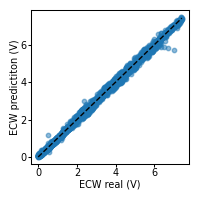

In [192]:
final_xgb_model = final_grid_search.best_estimator_
evaluate_model(final_xgb_model, final_X_test, final_y_test, figname="ECW", xlabel='ECW real (V)', ylabel='ECW predictiton (V)', figsize=(2, 2), output=True)

In [42]:
def evaluate_model_parallel(model, n_splits, X, y):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer, n_jobs=32)
    mae_scores = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer, n_jobs=32)
    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer, n_jobs=32)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer, n_jobs=32)
    
    scores = {
        'MSE': np.mean(-mse_scores),
        'MAE': np.mean(-mae_scores),
        'RMSE': np.mean(-rmse_scores),
        'R2': np.mean(r2_scores)
    }
    
    return scores

In [43]:
scores = evaluate_model_parallel(final_xgb_model, 5, final_X, y)
print(scores)

{'MSE': 0.002515655749671987, 'MAE': 0.030574566675604226, 'RMSE': 0.05014371364418859, 'R2': 0.9989446921604967}


<Figure size 2100x600 with 0 Axes>

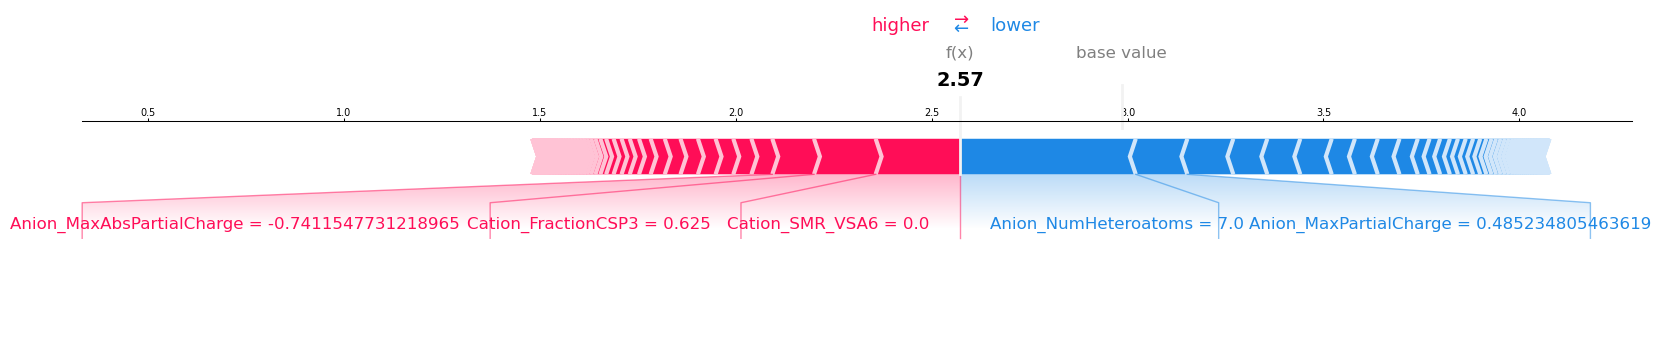

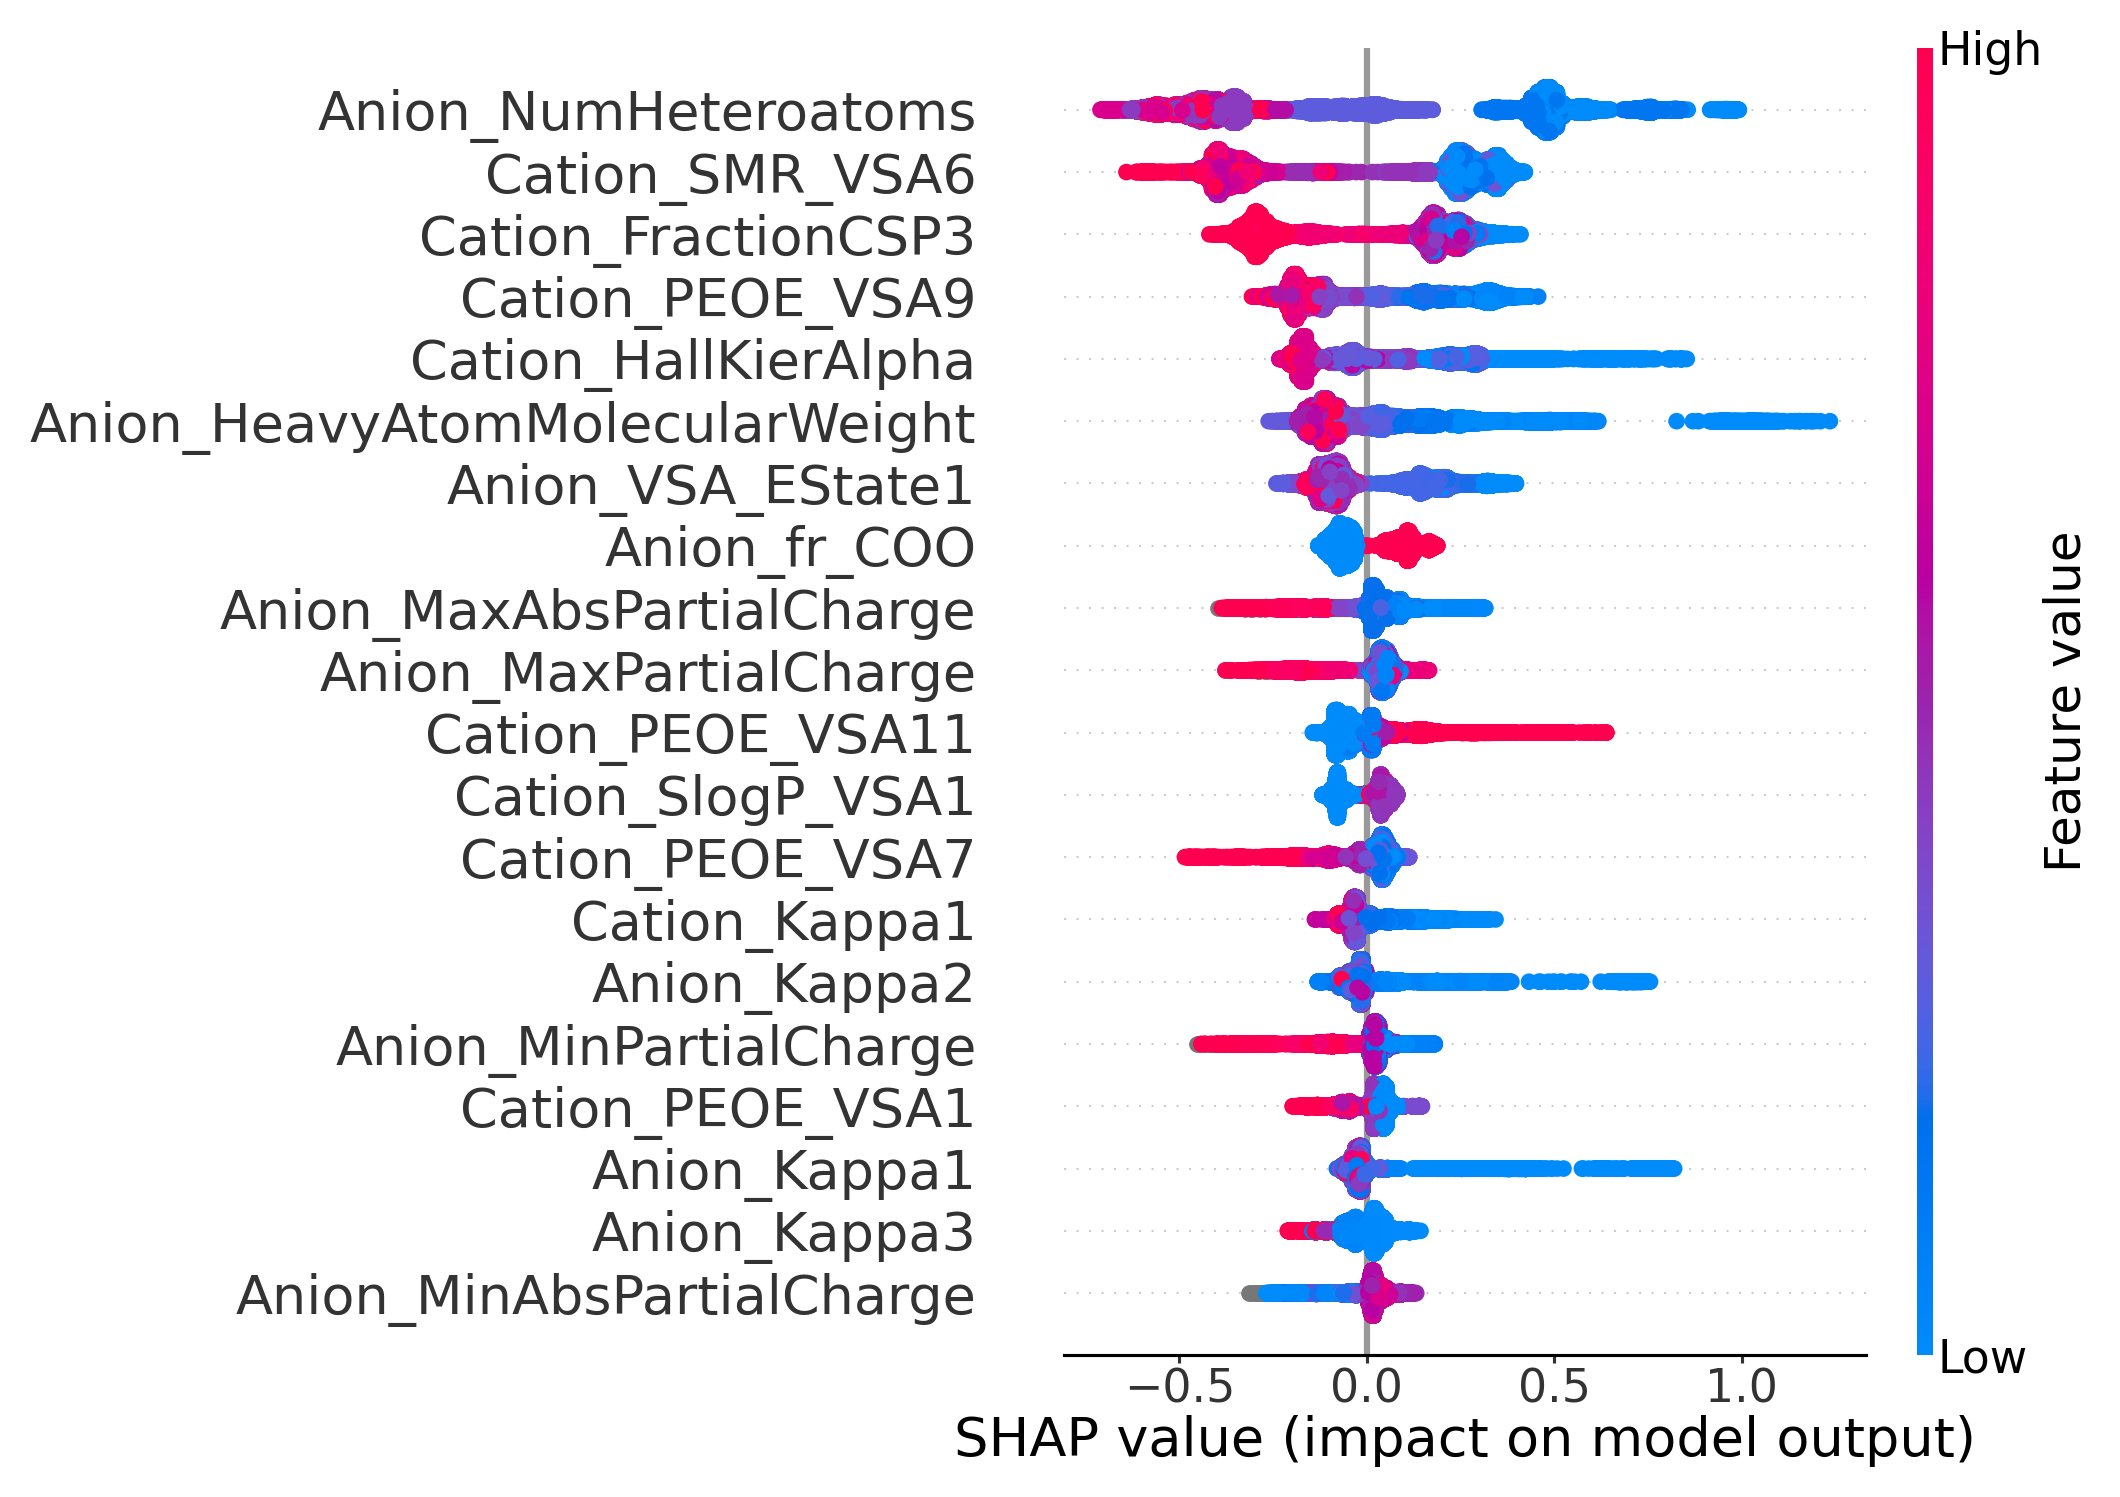

OrderedDict([('Anion_NumHeteroatoms', 0.39841506),
             ('Cation_SMR_VSA6', 0.31789452),
             ('Cation_FractionCSP3', 0.2401925),
             ('Cation_PEOE_VSA9', 0.18373796),
             ('Cation_HallKierAlpha', 0.1630735),
             ('Anion_HeavyAtomMolecularWeight', 0.12912965),
             ('Anion_VSA_EState1', 0.12869646),
             ('Anion_fr_COO', 0.081401825),
             ('Anion_MaxAbsPartialCharge', 0.07696015),
             ('Anion_MaxPartialCharge', 0.069856524),
             ('Cation_PEOE_VSA11', 0.05979216),
             ('Cation_SlogP_VSA1', 0.054989878),
             ('Cation_PEOE_VSA7', 0.054014873),
             ('Cation_Kappa1', 0.053863823),
             ('Anion_Kappa2', 0.050484207),
             ('Anion_MinPartialCharge', 0.04701182),
             ('Cation_PEOE_VSA1', 0.045856602),
             ('Anion_Kappa1', 0.044545963),
             ('Anion_Kappa3', 0.04034584),
             ('Anion_MinAbsPartialCharge', 0.039898016),
             ('

In [189]:
final_sorted_SHAP_importance_dict = SHAP(final_xgb_model, final_X, model_name='ECW', output=True)
final_sorted_SHAP_importance = OrderedDict(sorted(final_sorted_SHAP_importance_dict.items(), key=lambda t: t[1], reverse=True))
final_sorted_SHAP_importance

In [45]:
def save_model_with_joblib(model, filename):
    joblib.dump(model, filename)

In [46]:
save_model_with_joblib(final_xgb_model, 'ECW_xgb_model.joblib')

In [25]:
import joblib

def load_model_with_joblib_and_get_features(filename):
    model = joblib.load(filename)
    feature_names = model.get_booster().feature_names
    return model, feature_names

In [26]:
final_xgb_model, feature_names = load_model_with_joblib_and_get_features('Tm_xgb_model.joblib')
final_X = train_dataset[feature_names]
y = train_dataset['ECW (V)']

In [27]:
import shap
import matplotlib.pyplot as plt

def shap_analysis_for_xgboost(model, 
                              X, 
                              figsize=(2.3, 6), 
                              fontsize=7, 
                              fontfamily='Arial', 
                              linewidth=0.75,
                              save_fig=False,
                              fig_name="shap_summary_plot.png"):

    plt.rcParams['figure.figsize'] = figsize       
    plt.rcParams['font.size'] = fontsize                
    plt.rcParams['font.sans-serif'] = [fontfamily]     
    plt.rcParams['axes.linewidth'] = linewidth         
    plt.rcParams['lines.linewidth'] = linewidth      
    plt.rcParams['patch.linewidth'] = linewidth       

    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X)

    shap.summary_plot(shap_values, X, show=False)

    if save_fig:
        plt.savefig(fig_name, dpi=300, bbox_inches='tight')  
        print(f"SHAP figure save to : {fig_name}")

    plt.show()

In [ ]:
shap_analysis_for_xgboost(
    model=final_xgb_model, 
    X=final_X,
    figsize=(2.3, 6),      
    #fontsize=9,        
    fontfamily='Arial', 
    #linewidth=1.0,        
    save_fig=True,       
    fig_name="ECW_shap_plot.png"  
)